In [1]:
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
from mppi import InputFiles as I, Calculators as C, Datasets as D

# Analysis of the main functionality of the package

We discuss some explicit example to describe the main features of the module

## Inputs module :  construction of the pw input file

The Inputs module contains the PwIn class that allows us to built the input file of QuantumESPRESSO. 
The constructor of the class builds a generic input object with some 'standard' parameters that can be modified lately

In [2]:
input = I.PwIn()
print(input)

&control
          wf_collect = .true.
          pseudo_dir = '../pseudos'
        restart_mode = 'from_scratch'
           verbosity = 'high'
              prefix = 'out_dir'
/&end
&system
               ibrav = 4
/&end
ATOMIC_SPECIES
ATOMIC_POSITIONS { angstrom }
K_POINTS { automatic }
  1  1  1  0  0  0



A typical input for the computation of the Graphene can be built as follows

In [3]:
# set the relevant parameters
a0 = 1.42 #angstrom
planeSep  = 10.0
k = 6
e_cut = 60
a1 = [a0*np.sqrt(3),0.,0.]
a2 = [a0*np.sqrt(3)/2,a0*3./2,0.]
a3 = [0.,0.,planeSep]
A = [0.,0.,0.]
B = [0.,a0,0.]

input.atoms= [['C',A],['C',B]]
input.atypes = {'C': [12.011,"C_pbe-20082014.UPF"]}
input.system['nat'] = 2
input.system['occupations'] = "'smearing'"
input.system['smearing'] = "'fermi-dirac'"
input.system['degauss'] = 0.0036749326
input.system['ntyp'] = 1
input.system['ibrav'] = 0
input.electrons['conv_thr'] = 1e-8
input.kpoints = [k,k,1]
input.system['ecutwfc'] = e_cut
input.cell_parameters =[a1,a2,a3]
print(input)

&control
          wf_collect = .true.
          pseudo_dir = '../pseudos'
        restart_mode = 'from_scratch'
           verbosity = 'high'
              prefix = 'out_dir'
/&end
&system
               ibrav = 0
                 nat = 2
         occupations = 'smearing'
            smearing = 'fermi-dirac'
             degauss = 0.0036749326
                ntyp = 1
             ecutwfc = 60
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000   1.4200000000   0.0000000000
K_POINTS { automatic }
  6  6  1  0  0  0
CELL_PARAMETERS angstrom
  2.4595121467   0.0000000000   0.0000000000 
  1.2297560734   2.1300000000   0.0000000000 
  0.0000000000   0.0000000000  10.0000000000 



TODO : show how this module is able to open an existing file 

TODO : define a method that is able to update the input by passing the variables as a dictionary

## Calculators module : a calculator object for QuantumESPRESSO

Initialize the calculator

In [4]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


Specifies the input object, the name of the file and the run_dir, if post_processing is True the .run returns an instance of the pw_out method of qepppy and contains the results of the computation

In [5]:
results = code.run(input=input,name='test',run_dir='pw_run',post_processing=True)

skip the computation for : test.log


In [6]:
results.E_tot

-11.39932019258356

## Dataset module : how to manage several calculations

Show the functionality of this module by performin a convergence test for the ground state in function of the number of k-points and of the energy cutoff

In [7]:
code = C.QeCalculator(omp=1,mpi_run='mpirun -np 4',executable='pw.x',verbose=True,skip=True)

Initialize a qe calculator with command OMP_NUM_THREADS=1 mpirun -np 4 pw.x


In [8]:
study = D.Dataset(label='convergence_test',run_dir='gs_run_dir')

In [9]:
kpoints = [3,6,9,12]
ecut = [40,60,80]

In [10]:
for k in kpoints:
    for e in ecut:
        idd = {'k' : k, 'ecut' : e} 
        input.kpoints = [k,k,1]
        input.system['ecutwfc'] = e
        input.control['prefix'] = "'"+D.name_from_id(idd)+"'"
        study.append_run(id=idd,runner=code,input=input)

The paramaters of the dataset are given as follows, for instance

In [11]:
print(study.ids)
print(study.calculators)
print(study.runs[2])

[{'k': 3, 'ecut': 40}, {'k': 3, 'ecut': 60}, {'k': 3, 'ecut': 80}, {'k': 6, 'ecut': 40}, {'k': 6, 'ecut': 60}, {'k': 6, 'ecut': 80}, {'k': 9, 'ecut': 40}, {'k': 9, 'ecut': 60}, {'k': 9, 'ecut': 80}, {'k': 12, 'ecut': 40}, {'k': 12, 'ecut': 60}, {'k': 12, 'ecut': 80}]
[{'calc': <mppi.Calculators.Calculators.QeCalculator object at 0x7f7e827d9d30>, 'runs': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]}]
&control
          wf_collect = .true.
          pseudo_dir = '../pseudos'
        restart_mode = 'from_scratch'
           verbosity = 'high'
              prefix = 'ecut:80,k:3'
/&end
&system
               ibrav = 0
                 nat = 2
         occupations = 'smearing'
            smearing = 'fermi-dirac'
             degauss = 0.0036749326
                ntyp = 1
             ecutwfc = 80
/&end
&electrons
            conv_thr = 1e-08
/&end
ATOMIC_SPECIES
   C   12.011   C_pbe-20082014.UPF
ATOMIC_POSITIONS { angstrom }
  C   0.0000000000   0.0000000000   0.0000000000
  C   0.0000000000  

In [12]:
results = study.run(post_processing=True)

skip the computation for : ecut:40,k:3.log
skip the computation for : ecut:60,k:3.log
skip the computation for : ecut:80,k:3.log
skip the computation for : ecut:40,k:6.log
skip the computation for : ecut:60,k:6.log
skip the computation for : ecut:80,k:6.log
skip the computation for : ecut:40,k:9.log
skip the computation for : ecut:60,k:9.log
skip the computation for : ecut:80,k:9.log
skip the computation for : ecut:40,k:12.log
skip the computation for : ecut:60,k:12.log
skip the computation for : ecut:80,k:12.log


## Dataset module : post_processing of data

All the results of the dataset are stored in study.results as a list

In [13]:
study.results

{0: <qepppy.qe.pw_out.pw_out at 0x7f7e827d9c18>,
 1: <qepppy.qe.pw_out.pw_out at 0x7f7e827980b8>,
 2: <qepppy.qe.pw_out.pw_out at 0x7f7e827cbc18>,
 3: <qepppy.qe.pw_out.pw_out at 0x7f7e827dc0f0>,
 4: <qepppy.qe.pw_out.pw_out at 0x7f7e827c0978>,
 5: <qepppy.qe.pw_out.pw_out at 0x7f7e82740fd0>,
 6: <qepppy.qe.pw_out.pw_out at 0x7f7e827dc7f0>,
 7: <qepppy.qe.pw_out.pw_out at 0x7f7e82726f60>,
 8: <qepppy.qe.pw_out.pw_out at 0x7f7e827aecc0>,
 9: <qepppy.qe.pw_out.pw_out at 0x7f7e827d9b70>,
 10: <qepppy.qe.pw_out.pw_out at 0x7f7e827dc588>,
 11: <qepppy.qe.pw_out.pw_out at 0x7f7e826e1f98>}

And the associated parameters are written in the ids

In [14]:
study.ids

[{'k': 3, 'ecut': 40},
 {'k': 3, 'ecut': 60},
 {'k': 3, 'ecut': 80},
 {'k': 6, 'ecut': 40},
 {'k': 6, 'ecut': 60},
 {'k': 6, 'ecut': 80},
 {'k': 9, 'ecut': 40},
 {'k': 9, 'ecut': 60},
 {'k': 9, 'ecut': 80},
 {'k': 12, 'ecut': 40},
 {'k': 12, 'ecut': 60},
 {'k': 12, 'ecut': 80}]

The fetch_results method of Dataset can be used to extract a quantity, for instance the total energy E_tot,for a subset of the Dataset elements specified by a dictionary, as follows

In [15]:
data=study.fetch_results(id={'ecut': 40},attribute='E_tot')
data

[-11.35399815533371, -11.37225721728579, -11.3735615361433, -11.37390230022683]

It can also be used to plot the usual convergence analysis

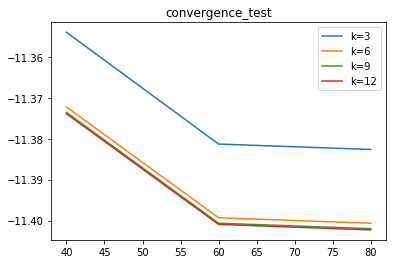

In [16]:
for k in kpoints:
    data=study.fetch_results(id={'k': k},attribute='E_tot')
    plt.plot(ecut,data,label='k='+str(k))
plt.title(study.label)
plt.legend()
plt.show()
    